# Time Series Analysis

## General Information on Time Series Analysis

- A special form of regression analysis that is concerned with the prediction of future development
- Definition Time Series: chronologically ordered sequence of observations in a given quantity
- Example areas of Application: economics, econometrics (GDP, unemployment rate), meteorology (temperature, wind, etc), remote sensing (vegetation development), political science (quantitative war andpeace research)

Distinction for household- or person-baseddata
if the Data is household- or personbased they are no longer time series data, but trend, panel, or event data.

## Prerequisites for the Time Series Analysis
### The data should be diskrete and not continous.
The difference between continuous and diskrete data is, that diskrete data is countable and continous data is not.

#### Examples for discrete data: 
value, temperature, weight; countable units that can't be infinitly broken down into smaller pieces

#### Examples for continous data: 
continous data are numeric values that can be scaled down infinitly. For example 13, 5.7, 1.5x10<sup>23</sup>

## Procedure of the time series analysis
### Exploratory analysis
Create a graphical representation of your current empirical values. Analyse the Data to find autocorrelation, seasonality and the stationarity of your dataset so that they can be taken into account in your model.

### Curve fitting
Construct a curve or a mathematical function, that best fits the series of the data points.

### Diagnosis Stage 
The use various procedures to asses the validity of the created model.

## Auto Regressive Model (AR)

It is a simple Regression on a single value by taking a time lag.


### $Y_{t} $= $\beta_{0}$ + $\beta _{1}$$Y_{t-1} $ + $\beta _{2}$$Y_{t-2} $ + $\beta _{3}$$Y_{t-3} $ .....


It works very good, if there is a good correlation between the past and the current values.

#### Auto Correlation:
It is the similarity between observations as a function of the time lag between them.

| Values | Shifted by 1 |
|:--------------:|:-------------:|
|250       |NAN       |
|300       |250       |
|200        |300     |
|400        |200       |
|450       |400       |
|500       |450      |
|...      |500      |

Via the PACF Function we can test the correlation between values:
![test](img/PAC.png)

## Moving Average Model (MA)

Moving Average is calculated by using Errors.

So instead of using the previous values like in AR-Model we use the Errors, that have been made by usind the AR-Model:

### $Y_{t} $= $\beta_{0}$ + $\beta _{1}$ $Y_{t-1} $ + $\epsilon_{1}$


The equation will be: 


### $Y_{t} $= $\beta$ + $\epsilon_{t}$ + $\theta_{1} $ $\epsilon_{t-1}$ +  $\theta_{2} $ $\epsilon_{t-2}$ + $\theta_{3} $ $\epsilon_{t-3}$ ....


#### Stationary Time Series:

* A series is stationary if the mean, variance ans covariance are constant over persiod of time.

* We can test, whether our time series is stationary or not using the ADF-Test (Augmented Dicky Fuller Test):

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: non-stationary

Alternate Hypothesis: stationary


If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.


* A series which is non-stationary can be made stationary by differencing:

| Values before differencing | after differencing once |
|:--------------:|:-------------:|
|250       |NAN       |
|300       |50       |
|200        |-100      |
|400        |200       |
|450       |50       |
|500       |50      |

We call it here integrated order of 1 --> I(1)

Via the ACF Function we can test the correlation between values:


![test](img/AC.png)

## Auto Regressive Integrated Moving Average Model (ARIMA)

#### Is the combination of all above models

ARIMA has 3 Parameters (p, d, q)

| Parameter | Meaning |
|:--------------:|:-------------:|
|p       |How many previous values we are taking to apply AR|
|d      |How many times we are using Differencing       |
|q        |The lag we are taking for Moving Average      |


### Akaike Information Criteria (AIC)

It is an Error Measure, so the minimum the AIC is, the better


### Advantages and disadvantages of ARIMA

#### Advantages
* ARIMA forecasts are usually more accurate and reliable.
* ARIMA combines autoregressive with moving average terms and can adjust to different levels of integration.
* It works better for relatively short series
* Easy to operate

#### Disadvantages

* No long-term predictions possible
* No automatic updating

# Implementation

## Imports

In [1]:
#pip install pmdarima
#pip install scikit-learn
#pip install numpy
#pip install pandas
#pip install matplotlib

import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import pmdarima as pm

from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.arima.stationarity import ADFTest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima.metrics import smape

from pandas.plotting import lag_plot
from pandas.plotting import register_matplotlib_converters

## Some configurations

In [2]:
register_matplotlib_converters() #Register a datetime converter for a matplotlib plotting method
#Include matplotlib graphs in the notebook, next to the code
%matplotlib inline 

## Define functions for later use

### Plot the data with different lags

In [34]:
def lag_auto_plot(data):
    fig, axes = plt.subplots(3, 2, figsize=(8, 12)) #Define 6 subplot (3 rows, 2 columns)

    # The axis coordinates for the plots (like a 2 (columns), 3 (rows) Matrix)
    ax_idcs = [
        (0, 0),
        (0, 1),
        (1, 0),
        (1, 1),
        (2, 0),
        (2, 1)
    ]

    for lag, ax_coords in enumerate(ax_idcs, 1):
        ax_row, ax_col = ax_coords
        axis = axes[ax_row][ax_col]
        lag_plot(data, lag=lag, ax=axis)
        axis.set_title(f"Lag={lag}")

    plt.show(block=False)

#A linear shape to the plot suggests that an autoregressive model is a good choice

### Forecast one period and update the model with the actual value, to optimize the next predictions

In [4]:
def forecast_one_step(forecastModel):
    fc, conf_int = forecastModel.predict(n_periods=1, return_conf_int=True) #Predict one period and return the confidence intervall (95%) for the prediction
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]) #Return prediciton and confidence intervalls as lists

def forecast_and_update_model(model, data):
    forecasts = []
    confidence_intervals = []
    for entry in data.Close: #For each entry in the test data set
        fc, conf = forecast_one_step(model) #Call the forecast (one period)
        forecasts.append(fc)
        confidence_intervals.append(conf) #Append prediction and confidence intervall to the defined lists

        # Updates the existing model with the actual value to optimize the next prediction
        model.update(entry)
    return (forecasts, confidence_intervals)

### Plot Actual vs Prediction as well the confidence intervall

In [5]:
def plot_prediction_vs_actual(trainData, testData, forecasts, confidence_intervals):
    fig = plt.gcf() #Create a figure
    fig.set_size_inches(16, 9) #Set the size of the figure

    # --------------------- Actual vs. Predicted --------------------------
#---Train Data---

#    plt.plot(trainData, 
#             color='blue', 
#             label='Train Data')


#---Predicted Price---
    plt.plot(testData.index, # Date for Prediction (x-axis)
             forecasts, # Prediction values (y-axis)
             color="green", 
             marker="o", #Set a circle for every prediction point
             label="Predicted Price")

#---Actual Price---
    plt.plot(testData.index, 
             testData, # Actual values
             color="red", 
             label="Actual Price")
    
    plt.legend(loc="best")
    plt.xlabel("Date")
    plt.ylabel("Volkswagen Closing Price")
    plt.title("Prediction vs Actual")
    plt.grid(True) # Set grid lines
    plt.show(block=False)


    # ------------------ Predicted with confidence intervals ----------------
    fig = plt.gcf()
    fig.set_size_inches(16, 9)

#---Train Data---
    
#    plt.plot(trainData
#             color='blue', 
#             label='Train Data')   

#---Predicted Price---
    plt.plot(testData.index, 
             forecasts, 
             color="green", 
             label="Predicted Price")
    
    plt.ylabel("Closing Price Volkswagen")
    plt.xlabel("Date in Months")

#---Confidence Intervall---    
    conf_int = np.asarray(confidence_intervals) # Save in a 2-dimensional array
    plt.fill_between(testData.index,
                    conf_int[:, 0], conf_int[:, 1], #U pper bound and lower bound for the confidence intervall in 1st and 2nd column
                    alpha=0.5, color="orange", # Set alpha to make the confidence intervall transparent
                    label="Confidence Intervals")
    plt.legend(loc="best")
    plt.title("Predictions & Confidence Intervals")
    plt.grid(True)
    plt.show(block=False)


### Evalutate model

In [6]:
def evaluate_model(testData, forecasts):
    print(f"Mean squared error: {mean_squared_error(testData, forecasts)}") 
    print(f"Mean absolut error: {mean_absolute_error(testData, forecasts)}") 
    print(f"R2 Score: {r2_score(testData, forecasts)}")

## Load the data

In [16]:
dfDataOrig = pd.read_csv("VOW3DE.csv", # Import Stock data of Volkswagen
                     parse_dates = True, # Keep date format
                     index_col = "Date", # Set the Data column as index
                     squeeze = True)

# Day Data

## Data Preperation

### Create the day dataset

In [17]:
dfDataDay = dfDataOrig.copy() # Create a copy, so the original data is not modified
dfDataDay = dfDataDay[["Close"]] # Keep only the Close Price column

#print(dfDataDay.head(5))
#print(dfDataDay.tail(5))
#print(dfDataDay.shape) #(5803, 1)
#print(dfDataDay.index) # dtype='datetime64[ns]', name='Date', length=5803, freq=None

### Split in training und test dataset

In [19]:
index = round(0.8*len(dfDataDay)) # Use 80% for training
trainDataDay = dfDataDay[:index] # Create train set
testDataDay = dfDataDay[index:] # Create test set

### Plot lags to see if Auto Regression makes sense

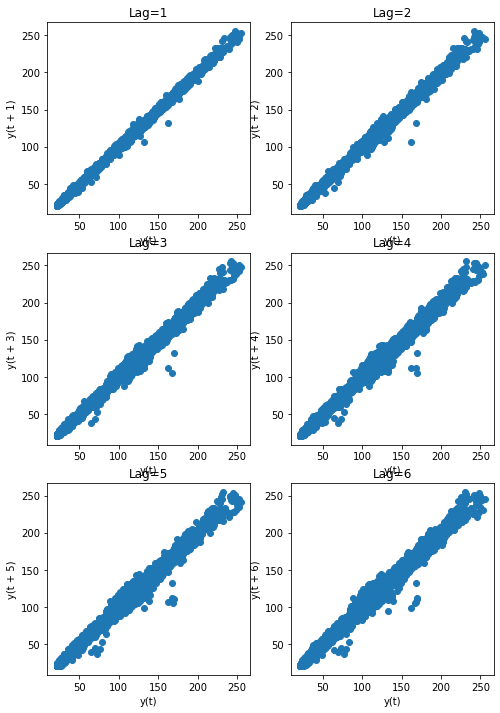

In [35]:
lag_auto_plot(trainDataDay) # Linear shape -> Auto Regression is a good choice

## Train the ARIMA model

### Determine Differentation Terms (d)

In [21]:
adf_test = ADFTest(alpha=0.05) # Confidence of 95%
p_val, should_diff = adf_test.should_diff(trainDataDay) # Test if a differentation is needed
#print(p_val, should_diff) #0.07508082249027766 True

In [35]:
# Two tests to get the number of differentations

kpss_diffs = ndiffs(trainDataDay, alpha=0.05, test='kpss', max_d=6) # Kwiatkowski–Phillips–Schmidt–Shin-Test
adf_diffs = ndiffs(trainDataDay, alpha=0.05, test='adf', max_d=6) # Augmented Dickey-Fuller-Test
n_diffs = max(adf_diffs, kpss_diffs) # Get max value of both tests

#print(f"Estimated differencing term: {n_diffs}") # Estimated differencing term: 1

NameError: name 'ndiffs' is not defined

### Determine Auto Regression Terms (p) and Moving Average Terms (q) with an automatic library function
Auto ARIMA : Returns best ARIMA model according to AIC value. The function conducts a search over possible model within the order constraints provided.

In [23]:
#autoArimaDay = pm.auto_arima(trainDataDay, 
#                     d=n_diffs, # Number of differentiation
#                     max_q = 5, #Max Number of Moving Average terms
#                     max_p=5, #Max Number of Auto Regression terms
#                     seasonal=False, #Non seasonal data
#                     stepwise=True, #Grid search
#                     suppress_warnings=True, 
#                     max_order=None, #No constraints for max order (p+q+P+Q)
#                     method='powell',# Powell method does not require the calculation of the derivatives of the relevant function and is one of the search methods
#                     trace=True # Show tests
#                    )
#Best model:  ARIMA(1,1,1)(0,0,0)[0]   

autoArimaDay = pm.ARIMA(order=(1,n_diffs,1), method="powell")
autoArimaDay.fit(trainDataDay, maxiter=200)


ARIMA(method='powell', order=(1, 1, 1))

## Test the model

### Forecast data

In [24]:
forecastsDay, conf_intDay = forecast_and_update_model(autoArimaDay, testDataDay)

### Plot Prediction vs Actual

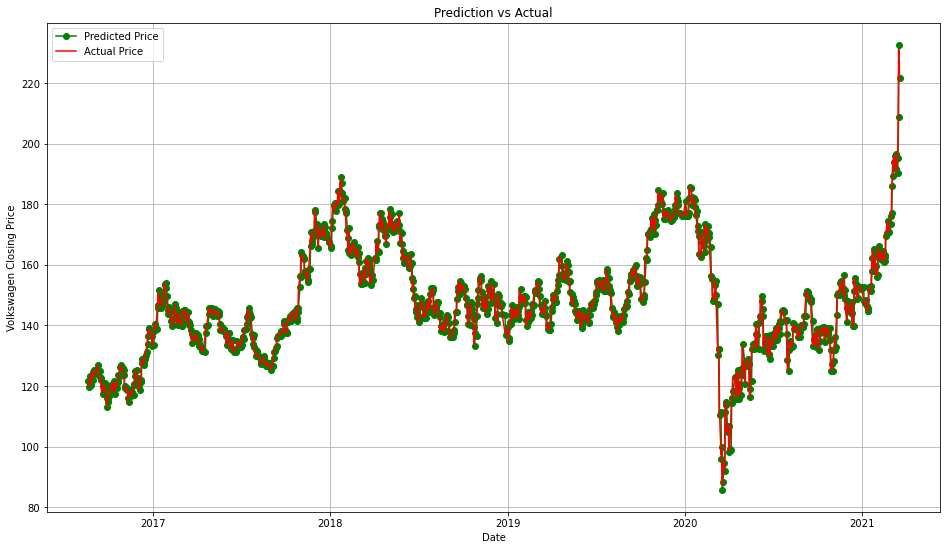

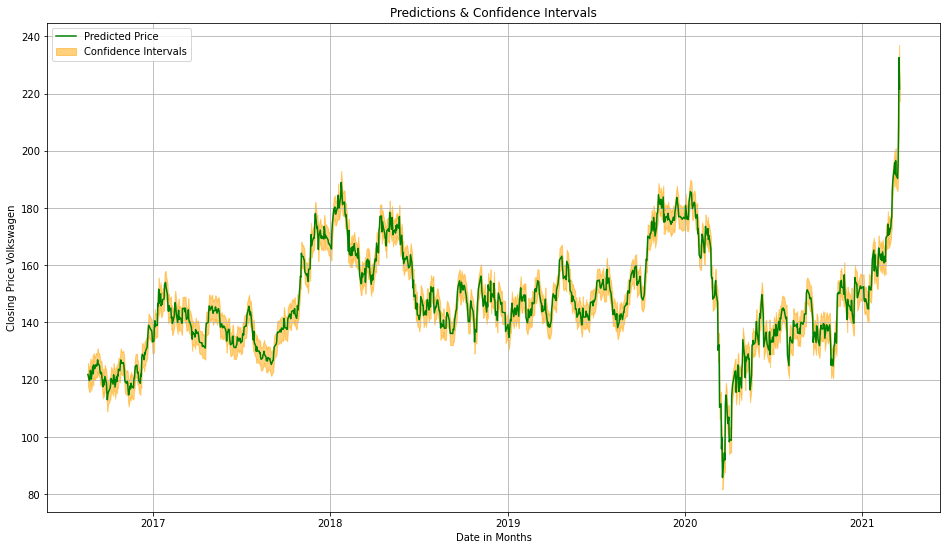

In [25]:
plot_prediction_vs_actual(trainDataDay, testDataDay, forecastsDay, conf_intDay)

### Evaluate model

In [26]:
evaluate_model(testDataDay, forecastsDay)

# Mean squared error: 8.76632079464574
# Mean absolut error: 2.0414405185952185
# R2 Score: 0.9720234226385642

Mean squared error: 8.76524836612931
Mean absolut error: 2.04175163659209
R2 Score: 0.9720234226342179


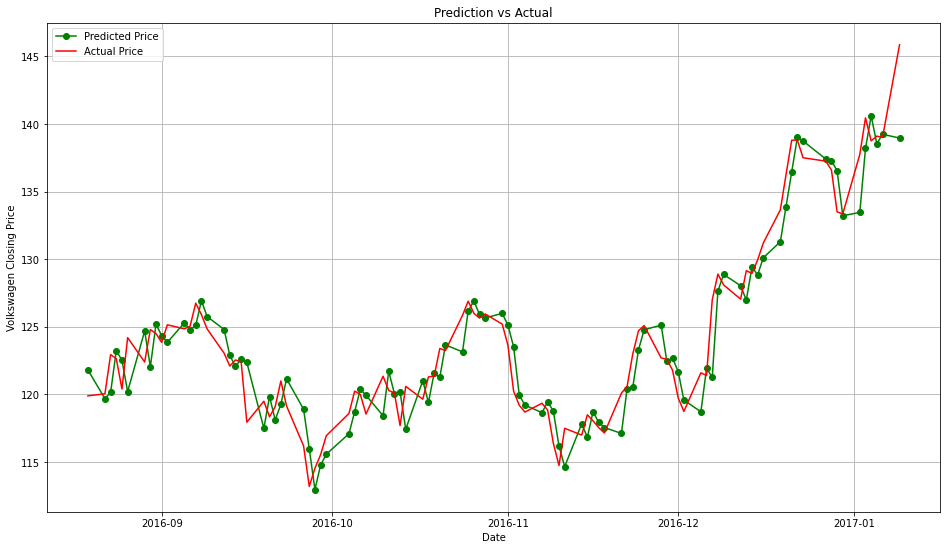

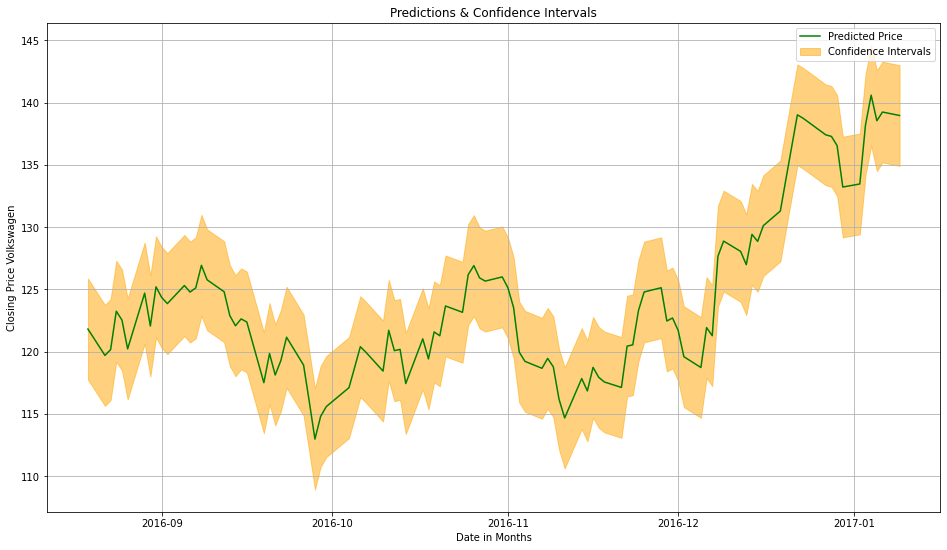

In [33]:
plot_prediction_vs_actual(trainDataDay, testDataDay[:100], forecastsDay[:100], conf_intDay[:100])

# Month Data

## Data Preperation

### Create the month dataset

In [31]:
dfDataMonth = dfDataOrig.copy() #Create a copy, so the original data is not modified
dfDataMonth = dfDataMonth[["Close"]] # Keep only the Close column
dfDataMonth = dfDataMonth.resample("M").mean() #Resample the data to get the mean for each month in a year

print(dfDataMonth.head(5))
#print(dfDataMonth.tail(5))
#print(dfDataMonth.shape) #(273, 1)
#print(dfDataMonth.index) # dtype='datetime64[ns]', name='Date', length=5803, freq=None

                Close
Date                 
1998-07-31  60.905651
1998-08-31  50.960141
1998-09-30  40.778897
1998-10-31  35.717161
1998-11-30  42.707353


### Split in training und test data

In [9]:
index = round(0.8*len(dfDataMonth)) #Use 80% for training
trainDataMonth = dfDataMonth[:index] 
testDataMonth = dfDataMonth[index:]

### Plot lags to see if Auto Regression makes sense

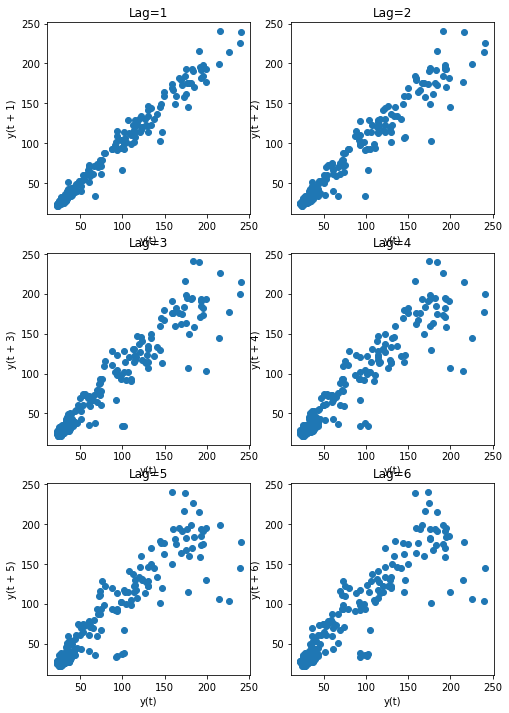

In [10]:
lag_auto_plot(trainDataMonth) #No linear shape -> Auto Regression not a good choice

### Determine Differentation Terms (d)

In [11]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(trainDataMonth)
print(p_val, should_diff) #0.2847947032599953 True

0.28479470325999545 True


In [12]:
kpss_diffs = ndiffs(trainDataMonth, alpha=0.05, test='kpss', max_d=6) #Kwiatkowski–Phillips–Schmidt–Shin-Test
adf_diffs = ndiffs(trainDataMonth, alpha=0.05, test='adf', max_d=6) #Augmented Dickey-Fuller-Test
n_diffs = max(adf_diffs, kpss_diffs) #Get max value of both tests

#print(f"Estimated differencing term: {n_diffs}") # Estimated differencing term: 1

### Determine Auto Regression Terms (p) and Moving Average Terms (q) with an automatic library function

In [13]:
#autoArimaMonth = pm.auto_arima(trainDataMonth, 
#                     d=n_diffs, # Number of differentiation
#                     max_q = 5, #Max Number of Moving Average terms
#                     max_p=5, #Max Number of Auto Regression terms
#                     seasonal=False, #Non seasonal data
#                     stepwise=True, #Grid search
#                     suppress_warnings=True, 
#                     max_order=None, #No constraints for max order (p+q+P+Q)
#                     method='powell',# modified Powell’s method
#                     trace=True # Show tests
#                    )
#Best model:  ARIMA(0,1,1)(0,0,0)[0] 

autoArimaMonth = pm.ARIMA(order=(0,n_diffs,1), method="powell")
autoArimaMonth.fit(trainDataMonth, maxiter=200)


ARIMA(method='powell', order=(0, 1, 1))

## Test the model

### Forecast data

In [14]:
forecastsMonth, conf_intMonth = forecast_and_update_model(autoArimaMonth, testDataMonth)

### Plot Prediction vs Actual

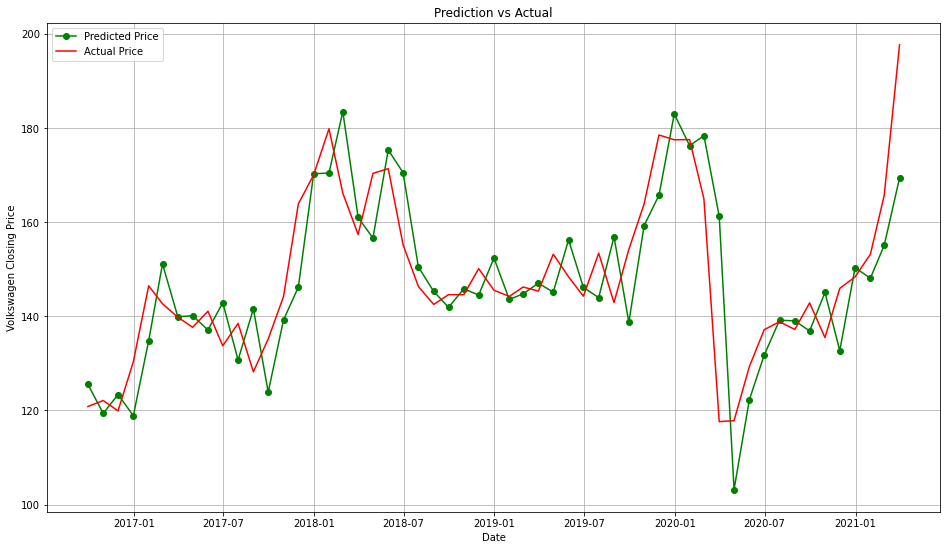

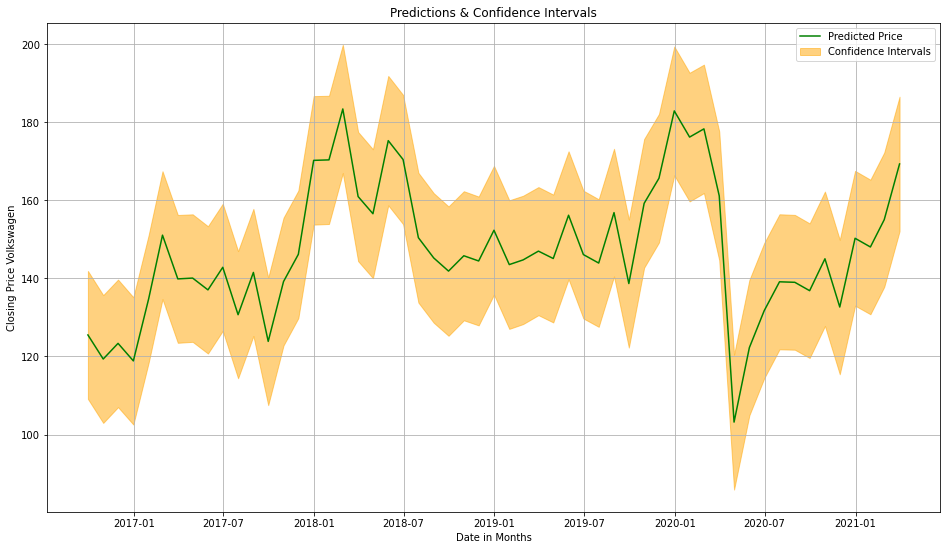

In [15]:
plot_prediction_vs_actual(trainDataMonth, testDataMonth, forecastsMonth, conf_intMonth)

### Evaluate model

In [16]:
evaluate_model(testDataMonth, forecastsMonth)

# Mean squared error: 120.84754399906895
# Mean absolut error: 8.102724236914167
# R2 Score: 0.5797799623058117

Mean squared error: 120.71666323001322
Mean absolut error: 8.105512446230353
R2 Score: 0.5802350706173753
